In [28]:
# multiclass classification
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, roc_auc_score, roc_curve, f1_score
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import model_selection
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.model_selection import train_test_split
import xgboost as xgb
from matplotlib import pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import RandomizedSearchCV

df = pd.read_csv('df-climatechange.csv')
df = df.drop(['qb1a'], axis = 1)
df['qb5'] = df['qb5'].replace({'No': 0, 'Yes':1})


#pd.set_option('display.max_columns', None)
df1 = df[df.qb2 >= 6]
df2 = df[df.qb2 <= 5]


In [29]:
#set parameters to search
parameters =    {
            'max_depth': [3, 4, 5],
            'learning_rate':  [0.1, 0.25, 0.5, 0.75, 1],
            'n_estimators': [50, 100, 150, 250],
            'gamma': [0.5, 1, 1.5, 2],
            'min_child_weight': [1, 5, 10], 
            }


parameters

{'max_depth': [3, 4, 5],
 'learning_rate': [0.1, 0.25, 0.5, 0.75, 1],
 'n_estimators': [50, 100, 150, 250],
 'gamma': [0.5, 1, 1.5, 2],
 'min_child_weight': [1, 5, 10]}

In [30]:
cc_num = df[['qb5', 'qb2', 'd1', 'd10','d11', 'country','d8','d25', 'd63','d7','cluster', 'cca']]
cat_var =['d1','d10', 'country','d8','d25', 'd63','d7','cluster', 'cca']

df_get_dummies = pd.get_dummies(  cc_num , columns = cat_var)



X = df_get_dummies.drop('qb5',axis=1)
y = df_get_dummies.loc[:, df_get_dummies.columns == 'qb5']

seed = 33# so that the result is reproducible
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.30, random_state = seed,stratify=y)

In [31]:
class_weights = compute_class_weight('balanced', classes = np.unique(y_train), y = np.ravel(y_train))
class_weights

array([1.43641457, 0.76697577])

In [32]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune, with class weight 
gb =xgb.XGBClassifier( class_weight={0: 1.43631197 , 1:0.76700502})
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
gb_classifier = RandomizedSearchCV(gb, parameters, cv = 3, n_jobs = -1,random_state = seed)
# Fit the random search model
gb_classifier.fit(X_train, y_train.values.ravel())


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(class_weight={0: 1.43631197,
                                                         1: 0.76700502}),
                   n_jobs=-1,
                   param_distributions={'gamma': [0.5, 1, 1.5, 2],
                                        'learning_rate': [0.1, 0.25, 0.5, 0.75,
                                                          1],
                                        'max_depth': [3, 4, 5],
                                        'min_child_weight': [1, 5, 10],
                                        'n_estimators': [50, 100, 150, 250]},
                   random_state=33)

In [41]:
print(gb_classifier.best_params_)
print(gb_classifier.best_estimator_)


{'n_estimators': 150, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 2}
XGBClassifier(class_weight={0: 1.43631197, 1: 0.76700502}, gamma=2,
              min_child_weight=5, n_estimators=150)


In [42]:
#I search manually for the scale_pos_weight parameters. In the model I put the found parameters with GridSearch

lr_list = [0.1, 0.25, 0.5, 0.75, 1]
for weight in lr_list:
    gb_clf = xgb.XGBClassifier(n_estimators=150, learning_rate=0.1, max_depth=3, random_state=seed,  scale_pos_weight=weight, class_weight={0: 1.43631197 , 1:0.76700502}, min_child_weight= 5, gamma = 2)
    gb_clf.fit(X_train,  y_train.values.ravel())
    print('scale_pos_weight: ' , weight)
    print("Accuracy score (validation): {0:.3f}".format(gb_clf.score(X_test, y_test.values.ravel())))

scale_pos_weight:  0.1
Accuracy score (validation): 0.376
scale_pos_weight:  0.25
Accuracy score (validation): 0.520
scale_pos_weight:  0.5
Accuracy score (validation): 0.655
scale_pos_weight:  0.75
Accuracy score (validation): 0.691
scale_pos_weight:  1
Accuracy score (validation): 0.709


In [33]:
#choose scale_pos_weight = 0.75
gb_classifier = xgb.XGBClassifier(n_estimators=150, learning_rate=0.1, max_depth=3, random_state=seed,  scale_pos_weight=0.75, class_weight={0: 1.43631197 , 1:0.76700502}, min_child_weight= 5, gamma = 2)

gb_classifier.fit(X_train,  y_train.values.ravel())
predictions = gb_classifier.predict(X_test)

target_names = ['No action', 'Yes action']
print(classification_report(y_test, gb_classifier.predict(X_test),target_names=target_names))

              precision    recall  f1-score   support

   No action       0.56      0.50      0.53      2296
  Yes action       0.75      0.79      0.77      4298

    accuracy                           0.69      6594
   macro avg       0.66      0.65      0.65      6594
weighted avg       0.68      0.69      0.69      6594



Text(0.5, 19.5, 'Predicted label')

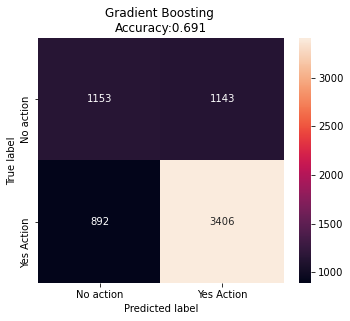

In [34]:
ac = accuracy_score(y_test,gb_classifier.predict(X_test))

plt.figure(figsize=(5.5,4.5))

cm_df = confusion_matrix(y_test,gb_classifier.predict(X_test))
cm_df = pd.DataFrame(cm_df,
                     index = ['No action','Yes Action'], 
                     columns = ['No action','Yes Action'])
sns.heatmap(cm_df,annot=True,fmt="d")
plt.title('Gradient Boosting \nAccuracy:{0:.3f}'.format(accuracy_score(y_test, gb_classifier.predict(X_test))))
plt.ylabel('True label')
plt.xlabel('Predicted label')
#plt.savefig('gb_confusionmatrix.png')


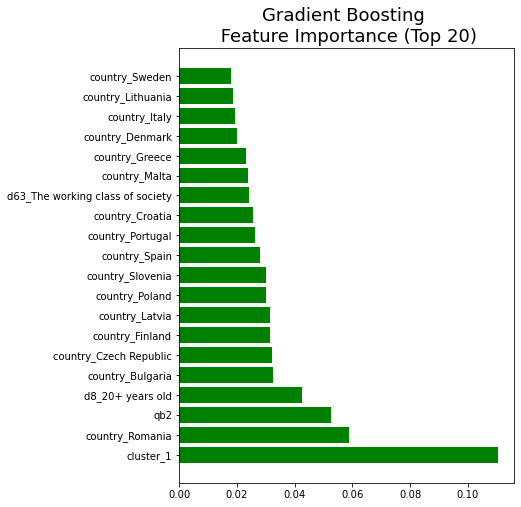

In [35]:
feature_importances = list(zip(X_train, gb_classifier.feature_importances_))
# Then sort the feature importances by most important first
feature_importances_ranked = sorted(feature_importances, key = lambda x: x[1], reverse = True)

feature_names_20 = [i[0] for i in feature_importances_ranked[:20]]
y_ticks = np.arange(0, len(feature_names_20))
x_axis = [i[1] for i in feature_importances_ranked[:20]]
plt.figure(figsize = (6, 8))
plt.barh(feature_names_20, x_axis, color = 'g')   #horizontal barplot
plt.title('Gradient Boosting \n Feature Importance (Top 20)',
          fontdict= {'fontsize' : 18})
plt.show()


In [36]:
imp = pd.read_csv('imp.csv')
imp  = imp.sort_values('variable', ascending=True).reset_index(drop=True)

dt = pd.DataFrame(feature_importances)
dt.rename(columns={ dt.columns[0]: "variable" }, inplace = True)

dt  = dt.sort_values('variable', ascending=True).reset_index(drop=True)

final = pd.merge(imp, dt, left_index=True, right_index=True)

final.rename(columns={ final.columns[5]: "importance_gb" }, inplace = True)
final.rename(columns={ final.columns[0]: "variable" }, inplace = True)
final = final.drop('variable_y', axis = 1)


final.to_csv('imp.csv', index=False, encoding='utf-8')

roc_auc_score for Gradient Boosting - High Risk Perception:  0.7397566767449375


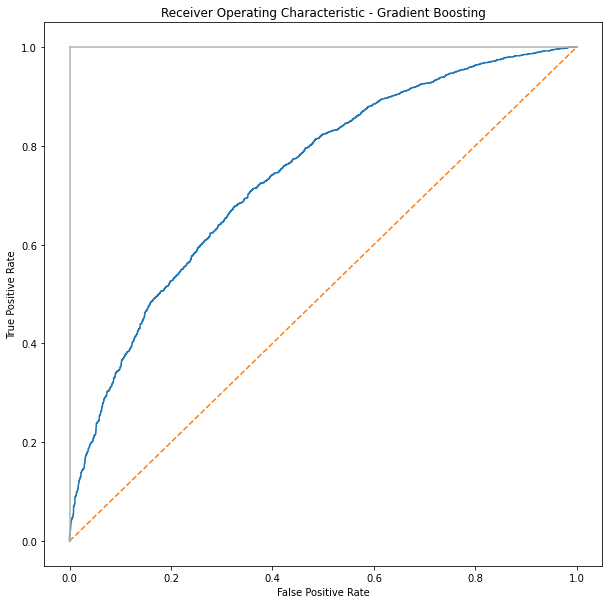

In [32]:
y_score2 = gb_classifier.predict_proba(X_test)[:,1]
false_positive_rate2, true_positive_rate2, threshold2 = roc_curve(y_test, y_score2)
print('roc_auc_score for Gradient Boosting - High Risk Perception: ', roc_auc_score(y_test, y_score2))
plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - Gradient Boosting')
plt.plot(false_positive_rate2, true_positive_rate2)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### High Risk Perception


In [9]:

cc_num = df1[['qb5' , 'd1', 'd10','d11', 'country','d8','d25', 'd63','d7','cluster', 'cca']]

cat_var =['d1','d10', 'country','d8','d25', 'd63','d7','cluster', 'cca']
df_get_dummies = pd.get_dummies(  cc_num , columns = cat_var)



X = df_get_dummies.drop('qb5',axis=1)
y = df_get_dummies.loc[:, df_get_dummies.columns == 'qb5']

seed = 555  # so that the result is reproducible
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.30, random_state = seed,stratify=y)

In [10]:
class_weights = compute_class_weight('balanced', classes = np.unique(y_train), y = np.ravel(y_train))
class_weights

array([1.56726931, 0.73424266])

In [11]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
gb =xgb.XGBClassifier( class_weight={0: 1.56739773 , 1:0.73421448})
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
gb_classifier = RandomizedSearchCV(gb, parameters, cv = 3, verbose=2, n_jobs = -1,random_state = seed)
# Fit the random search model
gb_classifier.fit(X_train, y_train.values.ravel())

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(class_weight={0: 1.56739773,
                                                         1: 0.73421448}),
                   n_jobs=-1,
                   param_distributions={'gamma': [0.5, 1, 1.5, 2],
                                        'learning_rate': [0.1, 0.25, 0.5, 0.75,
                                                          1],
                                        'max_depth': [3, 4, 5],
                                        'min_child_weight': [1, 5, 10],
                                        'n_estimators': [50, 100, 150, 250]},
                   random_state=555, verbose=2)

In [12]:
gb_classifier.best_params_

{'n_estimators': 150,
 'min_child_weight': 1,
 'max_depth': 4,
 'learning_rate': 0.25,
 'gamma': 2}

In [19]:
#I search manually for the scale_pos_weight and learning rate parameters. In the model I put the found parameters with GridSearch

lr_list = [0.1, 0.25, 0.5, 0.75, 1]
for learning in lr_list: 
    for weight in lr_list:
        gb_clf = xgb.XGBClassifier(n_estimators=150, learning_rate=learning, gamma = 2, max_depth=4, random_state=seed ,  scale_pos_weight=weight, class_weight={0: 1.56739773 , 1:0.73421448}, min_child_weight= 1)
        gb_clf.fit(X_train,  y_train.values.ravel())
        print('scale_pos_weight: ' , weight)
        print('learning rate: ' , learning)
        print("Accuracy score (validation): {0:.3f}".format(gb_clf.score(X_test, y_test.values.ravel())))

scale_pos_weight:  0.1
learning rate:  0.1
Accuracy score (validation): 0.355
scale_pos_weight:  0.25
learning rate:  0.1
Accuracy score (validation): 0.501
scale_pos_weight:  0.5
learning rate:  0.1
Accuracy score (validation): 0.666
scale_pos_weight:  0.75
learning rate:  0.1
Accuracy score (validation): 0.709
scale_pos_weight:  1
learning rate:  0.1
Accuracy score (validation): 0.714
scale_pos_weight:  0.1
learning rate:  0.25
Accuracy score (validation): 0.357
scale_pos_weight:  0.25
learning rate:  0.25
Accuracy score (validation): 0.510
scale_pos_weight:  0.5
learning rate:  0.25
Accuracy score (validation): 0.664
scale_pos_weight:  0.75
learning rate:  0.25
Accuracy score (validation): 0.710
scale_pos_weight:  1
learning rate:  0.25
Accuracy score (validation): 0.713
scale_pos_weight:  0.1
learning rate:  0.5
Accuracy score (validation): 0.369
scale_pos_weight:  0.25
learning rate:  0.5
Accuracy score (validation): 0.519
scale_pos_weight:  0.5
learning rate:  0.5
Accuracy score 

#### Best Model

In [13]:
#choose learning rate 0.25 scale_pos_weight = 0.5
gb_classifier =xgb.XGBClassifier(n_estimators=150, learning_rate=0.25, gamma = 2, max_depth=4, random_state=seed ,  scale_pos_weight=0.5, class_weight={0: 1.56739773 , 1:0.73421448}, min_child_weight= 1)
gb_classifier.fit(X_train, y_train)
predictions = gb_classifier.predict(X_test)

target_names = ['No action', 'Yes action']
print(classification_report(y_test, gb_classifier.predict(X_test),target_names=target_names))

C:\Users\giusp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


              precision    recall  f1-score   support

   No action       0.48      0.62      0.54      1825
  Yes action       0.79      0.68      0.73      3897

    accuracy                           0.66      5722
   macro avg       0.64      0.65      0.64      5722
weighted avg       0.69      0.66      0.67      5722



Text(0.5, 19.5, 'Predicted label')

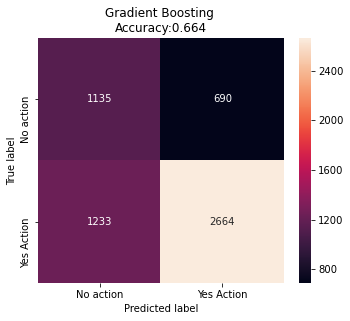

In [14]:
ac = accuracy_score(y_test,gb_classifier.predict(X_test))

plt.figure(figsize=(5.5,4.5))

cm_df = confusion_matrix(y_test,gb_classifier.predict(X_test))
cm_df = pd.DataFrame(cm_df,
                     index = ['No action','Yes Action'], 
                     columns = ['No action','Yes Action'])
sns.heatmap(cm_df,annot=True,fmt="d")
plt.title('Gradient Boosting \nAccuracy:{0:.3f}'.format(accuracy_score(y_test, gb_classifier.predict(X_test))))
plt.ylabel('True label')
plt.xlabel('Predicted label')
#plt.savefig('rf_confusionmatrix-df24.png')

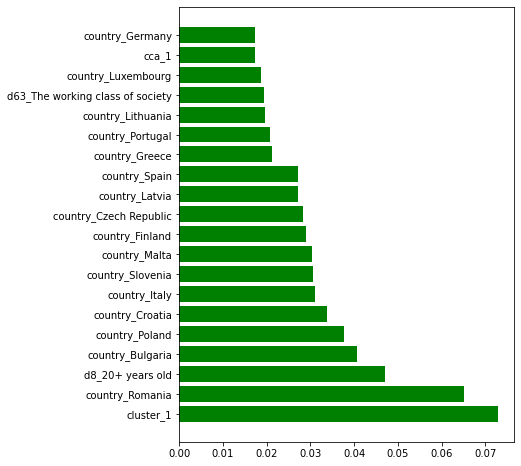

In [15]:
feature_importances = list(zip(X_train, gb_classifier.feature_importances_))
# Then sort the feature importances by most important first
feature_importances_ranked = sorted(feature_importances, key = lambda x: x[1], reverse = True)

feature_names_20 = [i[0] for i in feature_importances_ranked[:20]]
y_ticks = np.arange(0, len(feature_names_20))
x_axis = [i[1] for i in feature_importances_ranked[:20]]
plt.figure(figsize = (6, 8))
plt.barh(feature_names_20, x_axis, color = 'g')   #horizontal barplot
#plt.title('Gradient Boosting - Feature Importance (Top 20) \n High Risk Perception',
#          fontdict= {'fontsize' : 18})
#plt.xlabel('Features',fontdict= {'fontsize' : 16})
plt.show()


In [17]:
imp = pd.read_csv('imp2.csv')
imp  = imp.sort_values('variable', ascending=True).reset_index(drop=True)
dt = pd.DataFrame(feature_importances)
dt.rename(columns={ dt.columns[0]: "variable" }, inplace = True)
dt  = dt.sort_values('variable', ascending=True).reset_index(drop=True)
final = pd.merge(imp, dt, left_index=True, right_index=True)

final.rename(columns={ final.columns[5]: "importance_gb" }, inplace = True)
final.rename(columns={ final.columns[0]: "variable" }, inplace = True)
final = final.drop('variable_y', axis = 1)

final.to_csv('imp2.csv', index=False, encoding='utf-8')

roc_auc_score for Gradient Boosting - High Risk Perception:  0.7178841469201809


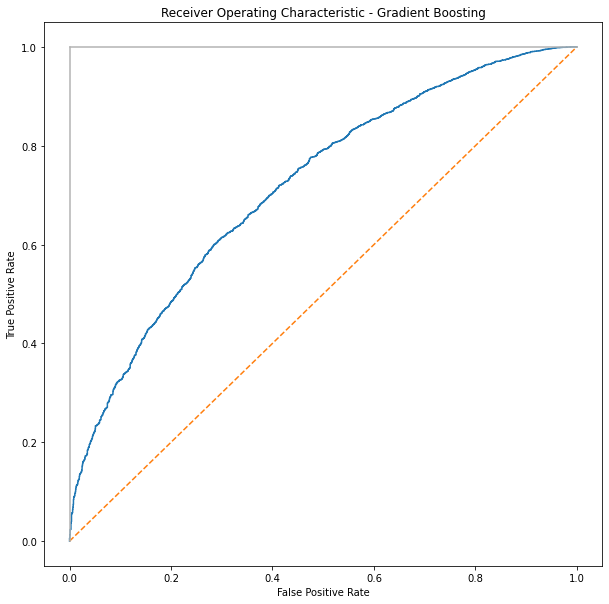

In [18]:
y_score2 = gb_classifier.predict_proba(X_test)[:,1]
false_positive_rate2, true_positive_rate2, threshold2 = roc_curve(y_test, y_score2)
print('roc_auc_score for Gradient Boosting - High Risk Perception: ', roc_auc_score(y_test, y_score2))
plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - Gradient Boosting')
plt.plot(false_positive_rate2, true_positive_rate2)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Low Risk Perception 


In [19]:
cc_num = df2[['qb5' , 'd1', 'd10','d11', 'country','d8','d25', 'd63','d7','cluster', 'cca']]

cat_var =['d1','d10', 'country','d8','d25', 'd63','d7','cluster', 'cca']
df_get_dummies = pd.get_dummies(  cc_num , columns = cat_var)


X = df_get_dummies.drop('qb5',axis=1)
y = df_get_dummies.loc[:, df_get_dummies.columns == 'qb5']

seed = 555  # so that the result is reproducible
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.333, random_state = seed,stratify=y)

In [20]:
class_weights = compute_class_weight('balanced', classes = np.unique(y_train), y = np.ravel(y_train))
class_weights

array([0.92727273, 1.08510638])

In [21]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
gb =xgb.XGBClassifier( class_weight={0: 0.92727273 , 1:1.08510638})
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
gb_classifier = RandomizedSearchCV(gb, parameters, cv = 3, verbose=2, n_jobs = -1, random_state = seed)
# Fit the random search model
gb_classifier.fit(X_train, y_train.values.ravel())

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(class_weight={0: 0.92727273,
                                                         1: 1.08510638}),
                   n_jobs=-1,
                   param_distributions={'gamma': [0.5, 1, 1.5, 2],
                                        'learning_rate': [0.1, 0.25, 0.5, 0.75,
                                                          1],
                                        'max_depth': [3, 4, 5],
                                        'min_child_weight': [1, 5, 10],
                                        'n_estimators': [50, 100, 150, 250]},
                   random_state=555, verbose=2)

In [22]:
gb_classifier.best_params_

{'n_estimators': 150,
 'min_child_weight': 1,
 'max_depth': 3,
 'learning_rate': 0.1,
 'gamma': 1}

In [23]:
#Learning rate:  0.5 #scale_pos_weight:  0.5
gb_classifier = xgb.XGBClassifier(n_estimators=150, learning_rate=0.1 , class_weight={0: 0.92727273 , 1:1.08510638}, min_child_weight =1, max_depth=3, gamma = 1,  random_state=seed)
gb_classifier.fit(X_train, y_train)
predictions = gb_classifier.predict(X_test)


target_names = ['No action', 'Yes action']
print(classification_report(y_test, gb_classifier.predict(X_test),target_names=target_names))

C:\Users\giusp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


              precision    recall  f1-score   support

   No action       0.62      0.70      0.66       522
  Yes action       0.58      0.50      0.54       446

    accuracy                           0.61       968
   macro avg       0.60      0.60      0.60       968
weighted avg       0.60      0.61      0.60       968



Text(0.5, 19.5, 'Predicted label')

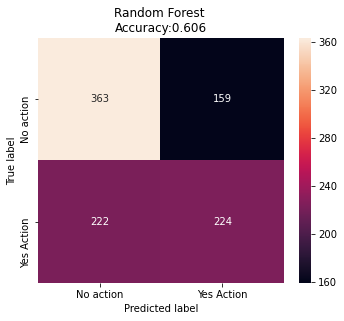

In [24]:
ac = accuracy_score(y_test,gb_classifier.predict(X_test))
plt.figure(figsize=(5.5,4.5))

cm_df = confusion_matrix(y_test,gb_classifier.predict(X_test))
cm_df = pd.DataFrame(cm_df,
                     index = ['No action','Yes Action'], 
                     columns = ['No action','Yes Action'])
sns.heatmap(cm_df,annot=True,fmt="d")
plt.title('Random Forest \nAccuracy:{0:.3f}'.format(accuracy_score(y_test, gb_classifier.predict(X_test))))
plt.ylabel('True label')
plt.xlabel('Predicted label')
#plt.savefig('rf_confusionmatrix-df24.png')

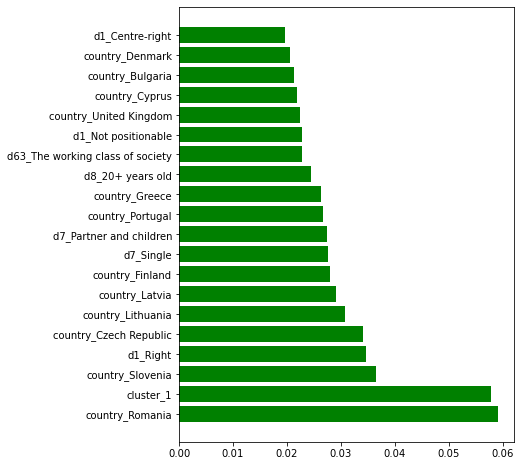

In [25]:
feature_importances = list(zip(X_train, gb_classifier.feature_importances_))
# Then sort the feature importances by most important first
feature_importances_ranked = sorted(feature_importances, key = lambda x: x[1], reverse = True)

feature_names_20 = [i[0] for i in feature_importances_ranked[:20]]
y_ticks = np.arange(0, len(feature_names_20))
x_axis = [i[1] for i in feature_importances_ranked[:20]]
plt.figure(figsize = (6, 8))
plt.barh(feature_names_20, x_axis, color = 'g')   #horizontal barplot
#plt.title('Gradient Boosting - Feature Importance (Top 20) \n Low Risk Perception',
#         fontdict= {'fontsize' : 20})
plt.show()

In [26]:
imp = pd.read_csv('imp3.csv')
imp  = imp.sort_values('variable', ascending=True).reset_index(drop=True)

dt = pd.DataFrame(feature_importances)
dt.rename(columns={ dt.columns[0]: "variable" }, inplace = True)

dt  = dt.sort_values('variable', ascending=True).reset_index(drop=True)

final = pd.merge(imp, dt, left_index=True, right_index=True)

final.rename(columns={ final.columns[5]: "importance_gb" }, inplace = True)
final.rename(columns={ final.columns[0]: "variable" }, inplace = True)
final = final.drop('variable_y', axis = 1)


final.to_csv('imp3.csv', index=False, encoding='utf-8')

roc_auc_score for Gradient Boosting - High Risk Perception:  0.6635267941515042


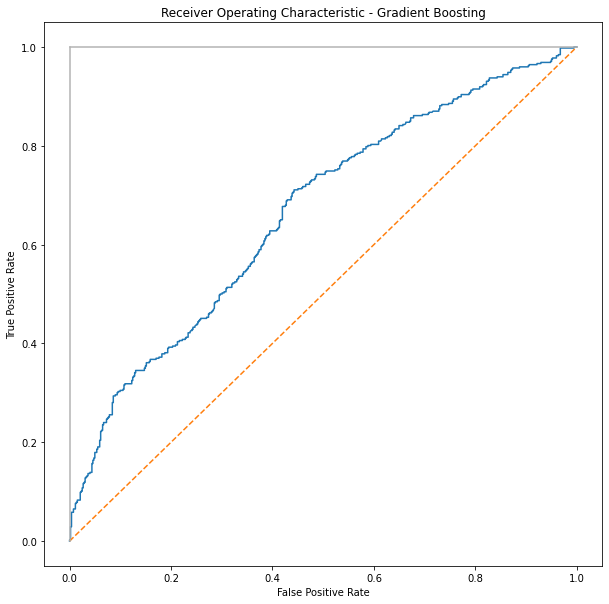

In [27]:
y_score2 = gb_classifier.predict_proba(X_test)[:,1]
false_positive_rate2, true_positive_rate2, threshold2 = roc_curve(y_test, y_score2)
print('roc_auc_score for Gradient Boosting - High Risk Perception: ', roc_auc_score(y_test, y_score2))
plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - Gradient Boosting')
plt.plot(false_positive_rate2, true_positive_rate2)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### REFERENCES

https://www.kaggle.com/henrylidgley/xgboost-with-hyperopt-tuning

https://stackoverflow.com/questions/54145714/grid-search-and-xgbclassifier-using-class-weights